## Imports

In [1]:
import transformers

ModuleNotFoundError: No module named 'transformers'

In [ ]:
from google.colab import drive
import numpy as np
import torch
import matplotlib.pyplot as plt
from safetensors.torch import save_file,load_file

drive.mount('/content/drive',force_remount=True)

# Effective Rank Analysis

In [ ]:
chan = np.load("chan_fisher_size4bit8nbexamples64Llama-3.1-8B.npy")[:, :16]
norm = np.load("norm_fisher_size4bit8nbexamples64Llama-3.1-8B.npy")[:, :16]


In [ ]:
plt.imshow(((chan-norm)/chan)>0)
plt.colorbar()
plt.show()

In [ ]:
Kvals = torch.linalg.svdvals(torch.Tensor(K).to("cuda"))
Vvals = torch.linalg.svdvals(torch.Tensor(V).to("cuda"))
Kvals_norm = Kvals/Kvals.sum(dim=1, keepdim=True)
Vvals_norm = Vvals/Vvals.sum(dim=1, keepdim=True)


In [ ]:
def effective_rank(norm_vals):
    # (bsz,d)
    effective_rank = torch.sum(-torch.log(norm_vals)*norm_vals, dim=1)
    return torch.exp(effective_rank)


In [ ]:
Kranks = effective_rank(Kvals_norm).cpu().numpy()
Vranks = effective_rank(Vvals_norm).cpu().numpy()


In [ ]:
plt.figure(figsize=(8, 5))
X = range(1, 33)
plt.plot(X, Kranks, marker='o',
         label="$W_K$ : Key Projection Matrixes", color="red")
plt.plot(X, Vranks, marker='o',
         label="$W_V$ : Value Projection Matrixes", color="blue")


plt.xticks(range(1, 33))


plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Layer id")
plt.ylabel("Effective Rank")
plt.title(
    "Effective Rank of Projection Matrixes $W_{K/V}$ per layer : Llama-3.1-8B")

plt.tight_layout()
plt.show()


In [ ]:
plt.plot(Kvals_norm[0].detach().cpu().numpy(), label="Layer 1")
plt.plot(Kvals_norm[14].detach().cpu().numpy(), label="Layer 15")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("id")
plt.ylabel("SVD Eigenvalue")
plt.title("Comparison : Sorted SVD Eigenvalues of $W_K$")

plt.tight_layout()
plt.show()


# Comparison : Residual quantization and product quantization

In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss
import numpy as np


def residual_quantization(X, n_centroids=256, n_iter=100, seed=1234):
    """
    Perform 2-stage residual quantization on X using FAISS
    """
    n, d = X.shape
    X = X.astype(np.float32)
    X1 = X[: int(0.4 * n)]
    X2 = X[int(0.4 * n) : int(0.8 * n)]
    X3 = X[int(0.8 * n) :]

    # Coarse quantization
    kmeans1 = faiss.Kmeans(d, n_centroids, niter=n_iter, seed=seed)
    kmeans1.train(X1)
    centroids1 = kmeans1.centroids
    _, codes2 = kmeans1.index.search(X2, 1)  # (n, 1)
    codes2 = codes2.flatten()
    _, codes31 = kmeans1.index.search(X3, 1)  # (n, 1)
    codes31 = codes31.flatten()

    # Compute Residuals
    residuals2 = X2 - centroids1[codes2]
    residuals3 = X3 - centroids1[codes31]

    # Quantize residuals
    kmeans2 = faiss.Kmeans(d, n_centroids, niter=n_iter, seed=seed + 1)
    kmeans2.train(residuals2)
    centroids2 = kmeans2.centroids
    _, codes32 = kmeans2.index.search(residuals3, 1)
    codes32 = codes32.flatten()
    reconstruction_error3 = X3 - centroids1[codes31] - centroids2[codes32]
    mse3 = (reconstruction_error3**2).mean()

    return mse3


def regular_quantization(X, n_centroids=256, n_iter=100, seed=1234):
    """
    Perform regular (1-stage) vector quantization using FAISS.
    """
    n, d = X.shape
    X = X.astype(np.float32)
    X1 = X[: int(0.7 * n)]
    X2 = X[int(0.7 * n) :]

    # Train k-means
    kmeans = faiss.Kmeans(d, n_centroids, niter=n_iter, seed=seed)
    kmeans.train(X1)
    centroids = kmeans.centroids

    # Assign each vector to its closest centroid
    _, codes2 = kmeans.index.search(X2, 1)
    codes2 = codes2.flatten()
    reconstruction_error2 = X2 - centroids[codes2]
    mse2 = (reconstruction_error2**2).mean()

    return mse2


def product_quantization(X, n_centroids=256, n_iter=100, seed=1234):
    n, d = X.shape
    return 0.5 * (
        regular_quantization(X[:, : d // 2], n_centroids, n_iter)
        + regular_quantization(X[:, d // 2 :], n_centroids, n_iter)
    )


data = load_file("drive/MyDrive/layer15_nb64split0.safetensors")


def temp_reshape(acts, n_channels):
    # (bsz,seqlen,d)
    bsz, seqlen, d = acts.shape
    if seqlen % n_channels != 0:
        acts = acts[:, : seqlen - seqlen % n_channels, :]
    acts = (
        acts.transpose(2, 1)
        .reshape(bsz, d, (acts.shape[1]) // n_channels, n_channels)
        .flatten(0, 2)
    )
    return acts


mses_res = np.zeros((5, 1024, 3))
mses_prod = np.zeros((5, 1024, 3))


for j, layer in enumerate([0, 4, 15, 25, 31]):
    data = load_file("drive/MyDrive/layer" + str(layer) + "_nb64split0.safetensors")
    for k, n_channels in enumerate([4, 8, 16]):
        print("_____________")
        print(k)
        for i in range(0, 256):
            if i % 100 == 0:
                print(i)
            vec = temp_reshape(
                data["acts_k"][:, 32:, i : i + 1], n_channels=n_channels
            ).numpy()
            mse_res = residual_quantization(vec)
            mse_prod = product_quantization(vec)
            mses_res[j, i, k] = mse_res
            mses_prod[j, i, k] = mse_prod

            # print(f"Residual MSE : {mse_res}")
            # print(f"Product MSE : {mse_prod}")


# Outlier analysis and 2D activation histograms

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"



In [ ]:
import torch

layer = 15
size_centroids = 4
data = load_file("drive/MyDrive/layer" + str(layer) + "_nb64split0.safetensors")
centroids_chan = load_file(
    "chanlayer" + str(layer) + "size" + str(size_centroids) + ".safetensors"
)
centroids_norm = load_file(
    "normlayer" + str(layer) + "size" + str(size_centroids) + ".safetensors"
)
centroids_kvquant = load_file(
    "kvquantlayer" + str(layer) + "size" + str(size_centroids) + ".safetensors"
)


In [ ]:
acts_k = data["acts_v"][:,8:].flatten(0,1)
grads2_k = data["grads_v"][:,8:].flatten(0,1)

In [ ]:
acts_k=acts_k.cuda()

In [ ]:
import numpy as np


def normalize_acts(acts):
    # (bsz,d)
    bsz, d = acts.shape
    means = torch.mean(acts, dim=0, keepdim=True)
    stds = torch.std(acts - means, dim=0, keepdim=True)
    acts = (acts - means) / stds
    return acts, means, stds


def temp_reshape(acts, n_channels):
    # (bsz,d)
    bsz, d = acts.shape
    acts = acts.reshape(bsz // n_channels, n_channels, 8, d // 8)
    acts = acts.reshape(
        bsz // n_channels, n_channels, 8, d // (8 * n_channels), n_channels
    )
    acts = (
        acts.transpose(2, 0).transpose(3, 1).transpose(3, 4)
    )  # (n_heads,32,newbatch,n_channels,n_channels)
    acts = acts.flatten(2, 3)  # (n_heads,32,newnewbatch,n_channels)
    return acts


def chan_reshape(acts, n_channels):
    # (bsz,seqlen,d)
    bsz, d = acts.shape
    acts = acts.reshape(bsz, 8, d // 8)
    acts = acts.reshape(bsz, 8, d // (8 * n_channels), n_channels)
    acts = acts.transpose(1, 0).transpose(2, 1)  # (n_heads,32,newbatch,n_channels)
    return acts


def assign(acts, centroids, quant_type, means=None, stds=None):
    # (bsz,seqlen,d)
    n_heads, subd, seqlen, n_chans = acts.shape  # (n_heads,32,newbatch,n_channels)
    centroids = centroids.transpose(2, 3)
    dotprods = torch.matmul(acts, centroids)
    normsacts = torch.linalg.norm(acts, dim=-1, keepdim=True) ** 2
    normscentroids = torch.linalg.norm(centroids, dim=-2, keepdim=True) ** 2
    # print(dotprods.shape,normsacts.shape,normscentroids.shape)
    dists = normsacts - 2 * dotprods + normscentroids
    codes = torch.argmin(dists, dim=-1)  # (n_heads,32,newbatch)
    # print(codes.min(),codes.max())
    newacts = centroids.transpose(2, 3)[
        torch.arange(codes.shape[0]).view(n_heads, 1, 1),
        torch.arange(codes.shape[1]).view(1, subd, 1),
        codes,
    ]  # (n_heads,32,newbatch,n_channels)
    # print(newacts.shape,acts.shape)
    print(((newacts - acts) ** 2).mean())
    print(f"acts stds : {acts.std()}")
    print(f"newacts stds : {newacts.std()}")
    print(f"centroids : {centroids.std()}")
    if means is not None:
        assert quant_type == "norm"
        newacts = (
            newacts.reshape(n_heads, subd, -1, n_chans, n_chans)
            .transpose(2, 3)
            .reshape(n_heads * subd * n_chans, -1)
        )
        newacts = newacts * stds.view(-1, 1) + means.view(-1, 1)
    else:
        assert quant_type == "chan"
        newacts = newacts.transpose(2, 3).reshape(n_heads * subd * n_chans, -1)
    newacts = newacts.transpose(1, 0)  # (bsz*seqlen,1024)
    return newacts


In [ ]:
acts_k = torch.Tensor(acts_k).cuda()
norm_acts_k, means, stds = normalize_acts(acts_k)
chan_acts = chan_reshape(acts_k, n_channels=size_centroids)
norm_acts = temp_reshape(norm_acts_k, n_channels=size_centroids)
assigned_norm = assign(
    norm_acts, torch.Tensor(centroids_norm["k"]).cuda(), "norm", means, stds
)
assigned_chan = assign(chan_acts, torch.Tensor(centroids_chan["k"]).cuda(), "chan")


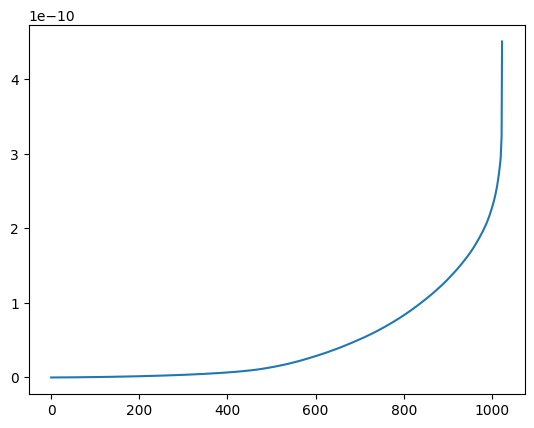

In [ ]:
mses_norm = (grads2_k.cuda()*(assigned_norm-acts_k)**2).mean(dim=0).cpu()
mses_chan = (grads2_k.cuda()*(assigned_chan-acts_k)**2).mean(dim=0).cpu()

## Analysis of the distribution of Fisher-Weighted Mean-Squared Errors

plt.plot(np.cumsum(np.sort(mses_norm)))
plt.show()

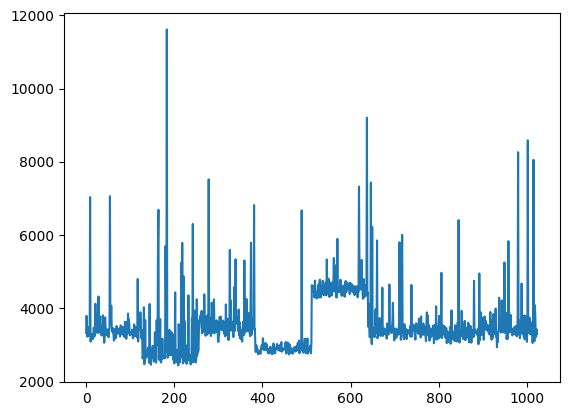

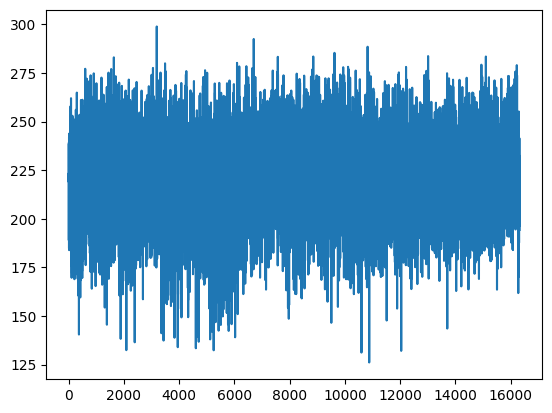

In [ ]:
## Magnitude analysis along the temporal and channel dimensions

plt.plot(torch.abs(acts_k).sum(dim=0).cpu())
plt.show()
plt.plot(torch.abs(acts_k).sum(dim=1).cpu().numpy())
plt.show()


In [ ]:
means1 = torch.mean(acts_k, dim=0, keepdim=True)
stds1 = torch.std(acts_k-means1, dim=0, keepdim=True)
acts_k1 = (acts_k - means1) / stds1

means0 = torch.mean(acts_k1, dim=1, keepdim=True)
stds0 = torch.std(acts_k1-means0, dim=1, keepdim=True)
acts_k0 = (acts_k1 - means0) / stds0


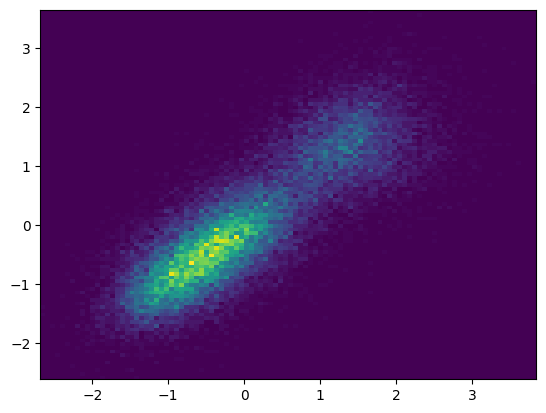

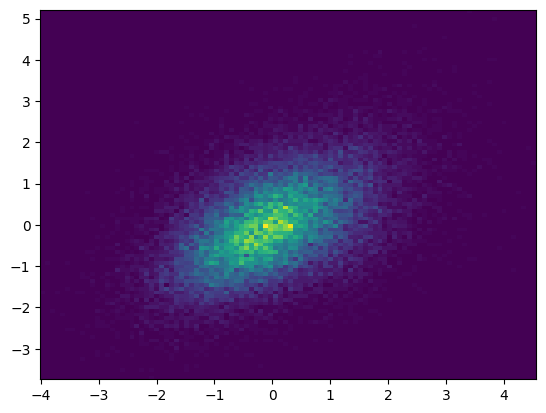

In [ ]:
## 2D histograms of adjacent tokens' channels

toplot1 = acts_k0.t().reshape(-1,2).cpu().numpy()
toplot2 = acts_k1.t().reshape(-1,2).cpu().numpy()

plt.hist2d(toplot1[:,0],toplot1[:,1],bins=100)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

plt.hist2d(toplot2[:,0],toplot2[:,1],bins=100)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()


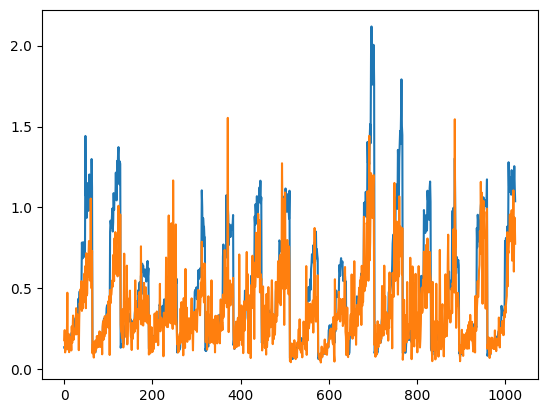

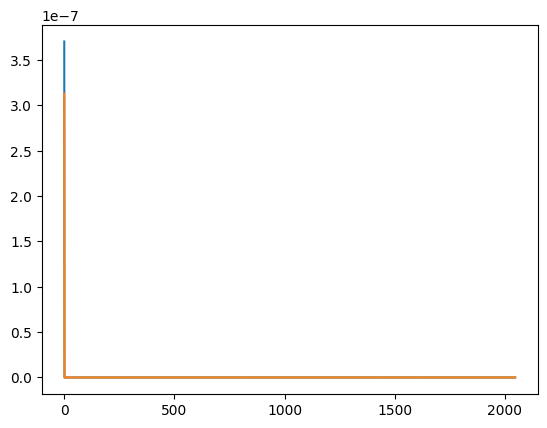

In [ ]:
## Plotting the different Fisher-weighted MSES depending on the channel

plt.plot(((assigned_chan-acts_k)**2).mean(dim=0).cpu().numpy())
plt.plot(((assigned_norm-acts_k)**2).mean(dim=0).cpu().numpy())
plt.show()
plt.plot((grads2_k.cuda()*(assigned_chan-acts_k)**2).mean(dim=1).cpu().numpy())
plt.plot((grads2_k.cuda()*(assigned_norm-acts_k)**2).mean(dim=1).cpu().numpy())
plt.show()